In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

## Load The Data

In [7]:
columns = ['Age', 'Sex', 'ChestPain', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


In [8]:
df_heart = pd.read_csv('heart.csv', names=columns, skiprows=1)

In [9]:
df_heart.head()

,Age,Sex,ChestPain,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [10]:
# Handle missing values
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_heart[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']] = imputer.fit_transform(df_heart[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']])


In [11]:
y = df_heart['HeartDisease']
X = df_heart.drop('HeartDisease', axis=1)
print(y.head())
print(X.head())

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64
    Age Sex ChestPain  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0  40.0   M       ATA      140.0        289.0          0     Normal  172.0   
1  49.0   F       NAP      160.0        180.0          0     Normal  156.0   
2  37.0   M       ATA      130.0        283.0          0         ST   98.0   
3  48.0   F       ASY      138.0        214.0          0     Normal  108.0   
4  54.0   M       NAP      150.0        195.0          0     Normal  122.0   

  ExerciseAngina  Oldpeak ST_Slope  
0              N      0.0       Up  
1              N      1.0     Flat  
2              N      0.0       Up  
3              Y      1.5     Flat  
4              N      0.0       Up  


### Encode Non Numerical Feature
Assigns numbers for features that are not originally numbers

In [12]:
# Encode categorical variables
encoder = OneHotEncoder()
X_encoded = pd.concat([pd.DataFrame(encoder.fit_transform(X[['Sex']]).toarray(), columns=['Female', 'Male']),
                       pd.DataFrame(encoder.fit_transform(X[['ChestPain']]).toarray(), columns=['ATA', 'ASY', 'NAP', 'TA']),
                       pd.DataFrame(encoder.fit_transform(X[['RestingECG']]).toarray(), columns=['LVH', 'Normal', 'ST']),
                       pd.DataFrame(encoder.fit_transform(X[['ExerciseAngina']]).toarray(), columns=['N', 'Y']),
                       pd.DataFrame(encoder.fit_transform(X[['ST_Slope']]).toarray(), columns=['Down', 'Flat', 'Up']),
                       X.drop(['Sex', 'ChestPain', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], axis=1)],
                       axis=1)

### Scale numerical features
Standardizes each feature by subtracting the mean and dividing by the standard deviation, resulting in a mean of 0 and a standard deviation of 1 for each feature

In [13]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']]),
                        columns=['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'])


In [14]:
# Concatenate the encoded and scaled features
X_processed = pd.concat([X_encoded, X_scaled], axis=1)
X_processed.head()

,Female,Male,ATA,ASY,NAP,TA,LVH,Normal,ST,N,...,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,140.0,289.0,0,172.0,0.0,-1.433140,0.410909,0.825070,1.382928,-0.832432
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,160.0,180.0,0,156.0,1.0,-0.478484,1.491752,-0.171961,0.754157,0.105664
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,130.0,283.0,0,98.0,0.0,-1.751359,-0.129513,0.770188,-1.525138,-0.832432
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,138.0,214.0,0,108.0,1.5,-0.584556,0.302825,0.139040,-1.132156,0.574711
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,150.0,195.0,0,122.0,0.0,0.051881,0.951331,-0.034755,-0.581981,-0.832432


### Remove Outliers
Remove 10% of outliers from the data with an isolation forest.

In [15]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.05)

outliers = iso_forest.fit_predict(X_processed)
X_filtered = X_processed[outliers == 1]
y_filtered = y[outliers == 1]

C:\Users\steph\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [16]:
X_filtered.shape

(872, 25)

In [17]:
y_filtered.shape

(872,)

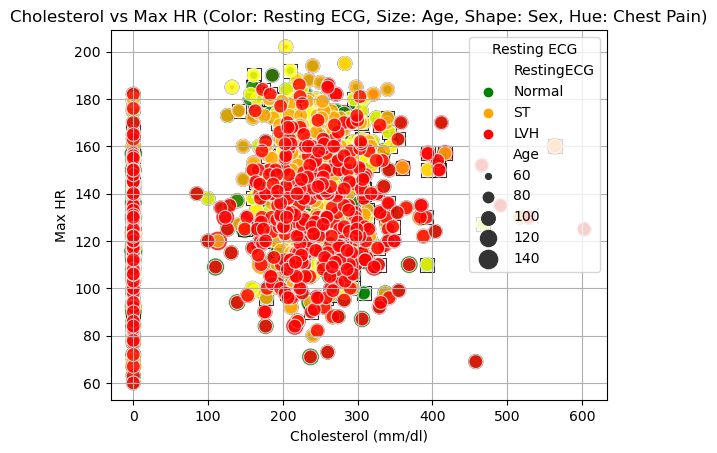

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define color palette for categorical variables
palette = {'M': 'blue', 'F': 'pink'}
chest_pain_palette = {'TA': 'green', 'ATA': 'yellow', 'NAP': 'orange', 'ASY': 'red'}
resting_ecg_palette = {'Normal': 'green', 'ST': 'orange', 'LVH': 'red'}

# Map categorical variables to colors
df_heart['Sex_Color'] = df_heart['Sex'].map(palette)
df_heart['ChestPain_Color'] = df_heart['ChestPain'].map(chest_pain_palette)
df_heart['RestingECG_Color'] = df_heart['RestingECG'].map(resting_ecg_palette)

# Define point sizes based on Age
sizes = df_heart['Age'] * 2

# Plot
sns.scatterplot(x='Cholesterol', y='MaxHR', hue='RestingECG', palette=resting_ecg_palette, size=sizes, sizes=(10, 200), data=df_heart, legend='brief', alpha=0.8)

# Customize legend
plt.legend(title='Resting ECG')

# Add Sex as shape marker
markers = {'M': 'o', 'F': 's'}
for category, marker in markers.items():
    sns.scatterplot(x='Cholesterol', y='MaxHR', color='none', style='Sex', markers={category: marker}, data=df_heart[df_heart['Sex'] == category], legend=False, edgecolor='black', s=100, alpha=0.8)

# Add ChestPain as hue
for category, color in chest_pain_palette.items():
    sns.scatterplot(x='Cholesterol', y='MaxHR', color='none', hue='ChestPain', palette={category: color}, data=df_heart[df_heart['ChestPain'] == category], legend=False, s=100, alpha=0.8)

# Add labels and title
plt.xlabel('Cholesterol (mm/dl)')
plt.ylabel('Max HR')
plt.title('Cholesterol vs Max HR (Color: Resting ECG, Size: Age, Shape: Sex, Hue: Chest Pain)')
plt.grid(True)
plt.show()

### Create the Train/Test split

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)



In [64]:
X_train.shape

(697, 25)

In [65]:
y_train.shape

(697,)

## SVM Classification

In [68]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
#default is rbf model

SVC()

In [69]:
y_pred_svc = svm_model.predict(X_test)
accuracy_score(y_test, y_pred_svc)

0.7371428571428571

In [74]:
print(metrics.classification_report(y_pred_svc, y_test))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        78
           1       0.76      0.76      0.76        97

    accuracy                           0.74       175
   macro avg       0.73      0.73      0.73       175
weighted avg       0.74      0.74      0.74       175



Text(113.9222222222222, 0.5, 'predicted label')

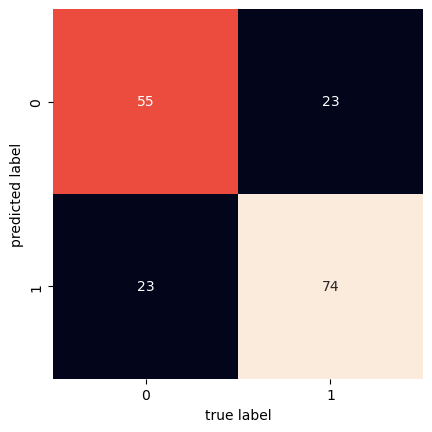

In [72]:
mat = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

# SVM Classification: Linear

In [29]:
svm_model_linear = SVC(kernel='linear')
svm_model_linear.fit(X_train, y_train)

SVC(kernel='linear')

In [31]:
y_pred_svc_linear = svm_model_linear.predict(X_test)

In [32]:
accuracy_score(y_test, y_pred_svc_linear)

0.8857142857142857

In [75]:
print(metrics.classification_report(y_pred_svc_linear, y_test))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        74
           1       0.92      0.88      0.90       101

    accuracy                           0.89       175
   macro avg       0.88      0.89      0.88       175
weighted avg       0.89      0.89      0.89       175



Text(113.9222222222222, 0.5, 'predicted label')

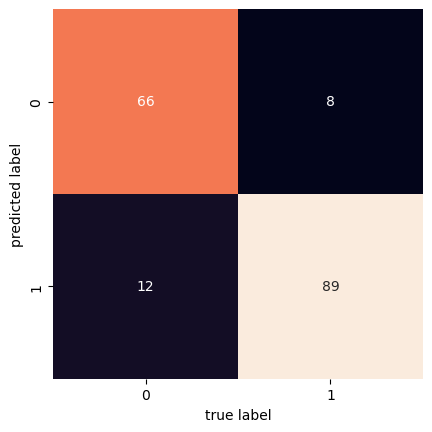

In [76]:
mat = confusion_matrix(y_test, y_pred_svc_linear)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

# SVM Classification: Polynomial (Quadratic)

In [41]:
svm_poly = SVC(kernel='poly', degree=2)
svm_poly.fit(X_train, y_train)

SVC(degree=2, kernel='poly')

In [42]:
y_pred_svc_poly = svm_poly.predict(X_test)

In [43]:
accuracy_score(y_test, y_pred_svc_poly)

0.7428571428571429

In [77]:
print(metrics.classification_report(y_pred_svc_poly, y_test))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70        73
           1       0.79      0.75      0.77       102

    accuracy                           0.74       175
   macro avg       0.74      0.74      0.74       175
weighted avg       0.75      0.74      0.74       175



Text(113.9222222222222, 0.5, 'predicted label')

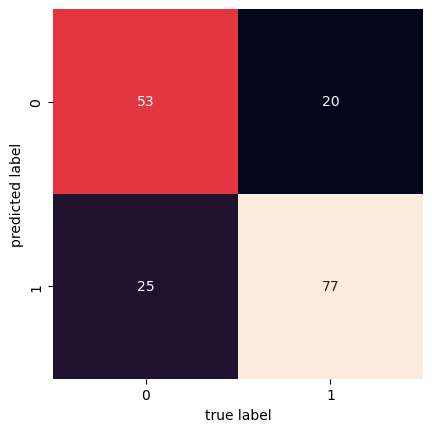

In [78]:
mat = confusion_matrix(y_test, y_pred_svc_poly)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

# Random Forest Classification

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
rfc = RandomForestClassifier(n_estimators=1000, random_state=0)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
#visualize_classifier(rfc, X_, y_train)

In [61]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
print(metrics.classification_report(y_pred_rfc, y_test))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85        68
           1       0.94      0.85      0.89       107

    accuracy                           0.87       175
   macro avg       0.87      0.88      0.87       175
weighted avg       0.88      0.87      0.88       175



Text(113.9222222222222, 0.5, 'predicted label')

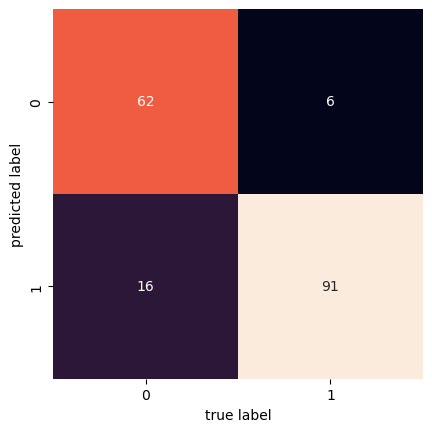

In [62]:
mat = confusion_matrix(y_test, y_pred_rfc)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

## Decision Tree Classification

In [23]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [24]:
y_pred_dt = dt.predict(X_test)
accuracy_score(y_test, y_pred_dt)

0.7771428571428571

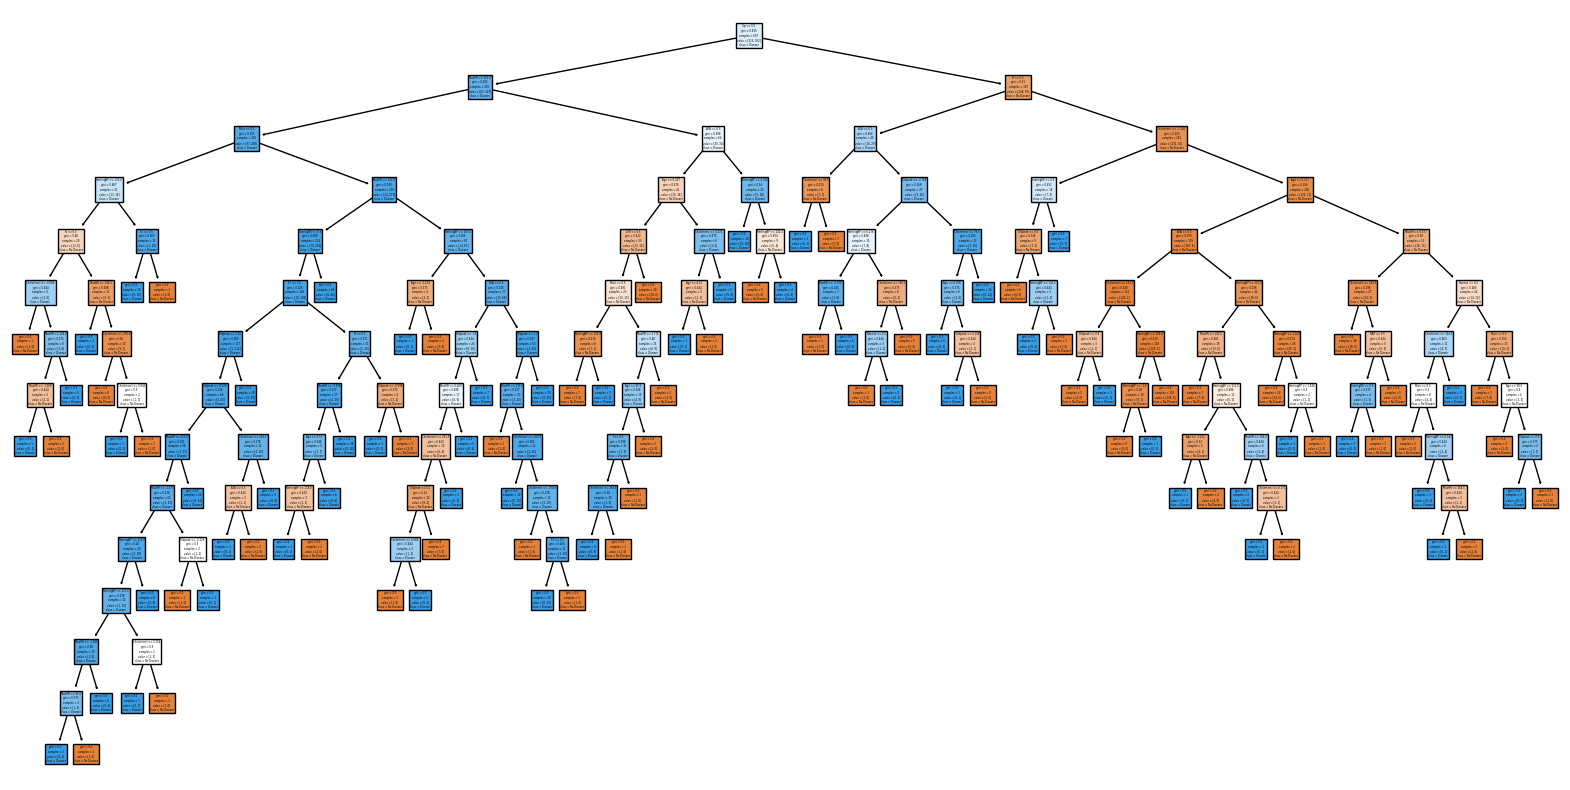

In [25]:
# Display the decision tree
feat_names = X_train.columns.tolist()
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=feat_names, class_names=['No Disease', 'Disease'])
plt.show()

In [26]:
dt.tree_.node_count

199

## Gradient Boosting Classification 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_t

In [28]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dt, out_file=None, filled=True, feature_names=feat_names, class_names=['No Disease', 'Disease'])
graph = graphviz.Source(dot_data)
graph.render("heart_disease_decision_tree")  # Save the tree as an image file

ModuleNotFoundError: No module named 'graphviz'